In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [2]:
import h5py
import numpy as np
particle_data_path ='dataset/brightfield_particles.hdf5'
with h5py.File(particle_data_path , 'r') as f:
    print(f['data'].shape)
    print(np.unique(f['labels'],return_counts=True))

(41350, 16, 201)
(array([0, 1, 2, 3]), array([32462,  8659,    60,   169]))


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
# from torchvision.models import vit_b_16
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torchvision.models.vision_transformer import VisionTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt

In [4]:
from torchvision.transforms import v2    
def compute_normalization_stats(h5_path, classes=None):
    """
    Compute mean and standard deviation for z-score normalization.
    
    Args:
        h5_path (str): Path to HDF5 file
        classes (list, optional): List of classes to include in computation
        
    Returns:
        tuple: (mean, std) computed across all data points
    """
    with h5py.File(h5_path, 'r') as h5_file:
        data = h5_file['data'][:]
        labels = h5_file['labels'][:]
        
        if classes is not None:
            # Filter data for selected classes
            mask = np.isin(labels, classes)
            data = data[mask]
        
        # Compute statistics across all dimensions
        mean = np.mean(data)
        std = np.std(data)
        
        print(f"Computed statistics: mean = {mean:.4f}, std = {std:.4f}")
        
        return mean, std
        
class ParticleDataset(Dataset):
    """Custom Dataset for particle data with flexible class selection and normalization."""
    def __init__(self, h5_path, classes=[0, 1], transform=None, mean=None, std=None,padding=False,indicies=list(range(0, 10000))):
        self.h5_file = h5py.File(h5_path, 'r')
        data = self.h5_file['data'][:]
        labels = self.h5_file['labels'][:]
        self.padding = padding
        # Filter data for selected classes
        mask = np.isin(labels, classes)
        if indicies is None:
            self.data = data[mask][:]
            self.labels = labels[mask][:] 
        else:
            self.data = data[mask][indicies]
            self.labels = labels[mask][indicies]
        
        # Create class mapping to handle non-consecutive class indices
        self.class_to_idx = {c: i for i, c in enumerate(classes)}
        self.num_classes = len(classes)
        
        # Map original labels to new consecutive indices
        self.labels = np.array([self.class_to_idx[label] for label in self.labels])
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get particle data
        particle = self.data[idx]  # Shape: (16, 201)
        
        # Apply normalization if mean and std are provided
        if self.mean is not None and self.std is not None:
            particle = (particle - self.mean) / self.std
        
        # Convert to torch tensor for better interpolation
        particle_tensor = torch.FloatTensor(particle).unsqueeze(0)  # Add channel dim
        
        # Resize to (16, 16) using bicubic interpolation
        resized = torch.nn.functional.interpolate(
            particle_tensor.unsqueeze(0),  # Add batch dim
            size=(16, 201),
            mode='bicubic',
            align_corners=True
        ).squeeze(0).squeeze(0)  # Remove batch and channel dims
        
        final_tensor = resized.unsqueeze(0).repeat(3, 1, 1)  # Repeat across 3 channels
        
        if self.transform:
            final_tensor = self.transform(final_tensor)
        
        # Create one-hot encoded label
        label_idx = self.labels[idx]
        label_onehot = torch.zeros(self.num_classes)
        label_onehot[label_idx] = 1
        
        return final_tensor, label_onehot

    def close(self):
        self.h5_file.close()     

In [5]:
import torch 

def distance_matrix(a, b):
    a_expanded = a.view(-1, 1)
    b_expanded = b.view(1, -1)

    return torch.abs(a_expanded - b_expanded)

def knn_divergence(points_x, points_y, k, smoothing_kernel=None):
    xx_distances = distance_matrix(points_x, points_x)
    xy_distances = distance_matrix(points_x, points_y) # one row for every sample in x, one col for every sample in y
    # print(xx_distances.shape, xy_distances.shape)
    # if the sets have different sizes
    # e.g. y has twice as many points -> the distance to the 3rd closest point in x should be the same as the distance to the 6th point in y
    k_multiplier = points_y.shape[0] / points_x.shape[0]

    k_dist_xx = torch.sort(xx_distances, dim=1)[0][:, k]
    k_dist_xy = torch.sort(xy_distances, dim=1)[0][:, (k * k_multiplier).to(torch.int)]

    # optional: smoothen the distances 
    # (so that it matters less whether a point is the i-th or the (i+1)-th closest neighbor)
    if smoothing_kernel != None:
            # torch conv1d demands a channel dimension, hence the (un)squeezing
            k_dist_xx = torch.nn.functional.conv1d(k_dist_xx.unsqueeze(1), weight=smoothing_kernel.view(1, 1, -1)).flatten(1)
            k_dist_xy = torch.nn.functional.conv1d(k_dist_xy.unsqueeze(1), weight=smoothing_kernel.view(1, 1, -1)).flatten(1)

    # return torch.mean((1 - k_dist_xx / k_dist_xy)**2)
    return torch.mean((k_dist_xx - k_dist_xy)**2)

In [6]:
from torchsummary import summary
# resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
# # resnet .fc = nn.Linear(resnet.fc.in_features, 1)
# resnet .fc = nn.Sequential(
#     nn.Linear(resnet.fc.in_features, 32),
#     nn.ReLU(),
#     nn.Linear(32, 1))
# summary(resnet, input_size=(3, 16, 201),device='cpu')

In [7]:
torch.manual_seed(42)
DEVICE = "cuda:11"
# Device configuration
device = torch.device(DEVICE if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# classes = [0]
transform = v2.Compose([
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
])
mean, std = compute_normalization_stats('dataset/brightfield_particles.hdf5', classes=[0])
dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[0],
                          mean=mean,
                          std=std,
                          padding=True,
                             transform = transform,
                             indicies=list(range(0, 20000)),
                         )

Using device: cuda:11
Computed statistics: mean = 7407.4357, std = 1323.8027


In [8]:
# def compute_contrast(img):
#     return (img.max()-img.min())/img.mean()
# img = dataset_80[0]

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

def generate_label_distribution(num_points=10000, mean=76, std=22.5, min_value=10, max_value=None):
    """
    Generate a tensor of points sampled from a normal distribution with specified mean and standard deviation
    while rejecting points outside the optional min and max value constraints.
    
    Args:
        num_points (int): Number of points to generate
        mean (float): Mean of the distribution
        std (float): Standard deviation of the distribution
        min_value (float, optional): Minimum value of the distribution (inclusive)
        max_value (float, optional): Maximum value of the distribution (inclusive)
    
    Returns:
        torch.Tensor: Tensor of generated points within the specified range
    """
    points = torch.empty(0)  # Initialize an empty tensor to store valid points

    while points.numel() < num_points:
        # Generate points from normal distribution
        generated_points = torch.normal(mean=mean, std=std, size=(num_points,))
        
        # Filter points based on the min and max values
        if min_value is not None:
            generated_points = generated_points[generated_points >= min_value]
        if max_value is not None:
            generated_points = generated_points[generated_points <= max_value]
        
        # Add the valid points to the tensor
        points = torch.cat((points, generated_points))
    # Return only the first `num_points` points
    return points[:num_points]
    
batch_size = 10000
num_points = 10000
dataloader_80 = DataLoader(dataset_80, batch_size=batch_size, shuffle=True)
label_points_80 = generate_label_distribution(num_points, mean=76, std=22.5)

In [10]:
def train_resnet(model, dataloaders, label_points, device, num_epochs=10, learning_rate=3e-2):
    """
    Train ResNet model using KNN divergence loss with early stopping and learning rate scheduling.
    
    Args:
        model (torch.nn.Module): ResNet model
        dataloader (torch.utils.data.DataLoader): Training dataloader
        label_points (torch.Tensor): Pre-generated label points
        device (torch.device): Device to train on
        num_epochs (int): Number of training epochs
        learning_rate (float): Learning rate for optimizer
    
    Returns:
        model: Trained model
        best_loss: Best training loss achieved
    """
    # Move label points to the specified device
    labels = [label.to(device, non_blocking=True) for label in label_points] 
    # labels_80, labels_300 = labels[0],labels[1] 
    # Prepare k values for KNN divergence
    ks = [torch.arange(2, label_point.shape[0]//10, dtype=torch.int) for label_point in label_points]    
    # Setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Setup learning rate scheduler with patience of 8
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=8, factor=0.5
    )
    
    model.to(device)
   
    # Early stopping parameters
    best_loss = float('inf')
    patience = 20
    patience_counter = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        batch_count = 0
        
        for idx, (label, dataloader) in enumerate(zip(labels, dataloaders)):
                for batch_images, _ in dataloader:
                    batch_count += 1
                    gt = torch.clone(label)
                    batch_images = batch_images.to(device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass: generate predictions
                    batch_predictions = model(batch_images)
                    
                    # Compute KNN divergence loss
                    loss = knn_divergence(batch_predictions, gt, ks[idx])
                    
                    # Backward pass and optimize
                    loss.backward()
                    optimizer.step()
                    
                    total_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_loss = total_loss / batch_count
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, LR: {current_lr:.2e}')
        
        # Learning rate scheduling
        scheduler.step(avg_loss)
        
        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                # Restore best model
                model.load_state_dict(best_model_state)
                break
    
    return model, best_loss

In [11]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
dataloaders = (dataloader_80,)
label_points = (label_points_80,)
# resnet .fc = nn.Linear(resnet.fc.in_features, 1)
resnet .fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)
resnet,best_loss = train_resnet(resnet, dataloaders, label_points, device, num_epochs=300)
resnet.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch [1/300], Loss: 1075.6255, LR: 3.00e-02
Epoch [2/300], Loss: 206.3188, LR: 3.00e-02
Epoch [3/300], Loss: 5.2334, LR: 3.00e-02
Epoch [4/300], Loss: 33.5740, LR: 3.00e-02
Epoch [5/300], Loss: 26.1509, LR: 3.00e-02
Epoch [6/300], Loss: 38.9280, LR: 3.00e-02
Epoch [7/300], Loss: 2.9473, LR: 3.00e-02
Epoch [8/300], Loss: 3.4402, LR: 3.00e-02
Epoch [9/300], Loss: 11.5037, LR: 3.00e-02
Epoch [10/300], Loss: 4.7968, LR: 3.00e-02
Epoch [11/300], Loss: 2.1725, LR: 3.00e-02
Epoch [12/300], Loss: 2.0835, LR: 3.00e-02
Epoch [13/300], Loss: 3.6130, LR: 3.00e-02
Epoch [14/300], Loss: 4.4650, LR: 3.00e-02
Epoch [15/300], Loss: 2.9428, LR: 3.00e-02
Epoch [16/300], Loss: 1.4080, LR: 3.00e-02
Epoch [17/300], Loss: 0.8755, LR: 3.00e-02
Epoch [18/300], Loss: 1.1974, LR: 3.00e-02
Epoch [19/300], Loss: 1.5476, LR: 3.00e-02
Epoch [20/300], Loss: 1.0721, LR: 3.00e-02
Epoch [21/300], Loss: 0.9007, LR: 3.00e-02
Epoch [22/300], Loss: 0.8926, LR: 3.00e-02
Epoch [23/300], Loss: 0.8274, LR: 3.00e-02
Epoch [24/3

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
resnet.eval()
resnet(dataset_80[0][0].unsqueeze(0).to(device))

tensor([[123.9284]], device='cuda:11', grad_fn=<AddmmBackward0>)

In [13]:
with torch.no_grad():
    a= next(iter(dataloader_80))[0]
    out  = resnet(a.to(device))

In [14]:
out.max()

tensor(133.8382, device='cuda:11')

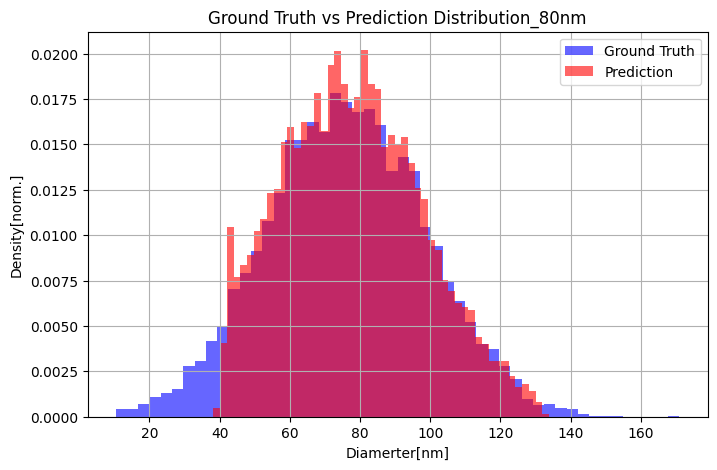

In [15]:
# Plot histograms
plt.figure(figsize=(8, 5))
plt.hist(label_points_80 , bins=50, alpha=0.6, label='Ground Truth', color='blue', density=True)
plt.hist(out.cpu().detach().numpy(), bins=50, alpha=0.6, label='Prediction', color='red', density=True)

# Labels and legend
plt.xlabel('Diamerter[nm]')
plt.ylabel('Density[norm.]')
plt.title('Ground Truth vs Prediction Distribution_80nm')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [16]:
plot_dataset_300 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[1],
                          mean=mean,
                          std=std,
                          padding=True,
                        transform = None,
                        indicies = None
                         )
plot_dataloader_300 = DataLoader(plot_dataset_300 , batch_size=len(plot_dataset_300))
with torch.no_grad():
    out_2 = next(iter(plot_dataloader_300))[0]
    out_2  = resnet(out_2.to(device)).cpu().detach().numpy()
label_points_300 = generate_label_distribution(len(plot_dataset_300), mean=302, std=25)
print(out_2.mean())

84.54833


In [50]:
def compute_contrast(imgs:torch.Tensor,dim=(1, 2, 3)):
    """
        args:
            imgs:batch_images
            dim: dim
        return
            output: contrast value of each image in the batch
    """
    return (imgs.amax(dim=dim)-img.amax(dim=dim))/img.mean(dim=dim)
out
with torch.no_grad():
    a = next(iter(dataloader_80))[0]
    c = compute_contrast(a)
    sorted_indices = torch.argsort(c) 
    a=a[sorted_indices]
    out = resnet(a.to(device))
plt.scatter(list(range(0,len(out[0:1000]))),out[0:1000].cpu())

In [ ]:
import matplotlib.pyplot as plt
# Example list of values
# values =out_2+(302-out_2.mean())
values =out_2
# values = o
# Set up the plot
plt.figure(figsize=(8, 6))

# Plot the histogram
plt.hist(values, bins=50, color='red',label='Prediction',alpha=0.7, density=True)
plt.hist(label_points_300  , bins=50, alpha=0.6, label='Ground Truth', color='blue', density=True)
# Add labels
# Labels and legend
plt.xlabel('Diamerter[nm]')
plt.ylabel('Density[norm.]')
plt.title('Ground Truth vs Prediction Distribution_300nm')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [ ]:
plot_dataset_1300 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[2],
                          mean=mean,
                          std=std,
                          padding=True,
                        transform = None,
                        indicies=None
                         )
plot_dataloader_1300 = DataLoader(plot_dataset_1300, batch_size=len(plot_dataset_1300))
with torch.no_grad():
    out_3 = next(iter(plot_dataloader_1300))[0]
    out_3  = resnet(out_3.to(device)).cpu().detach().numpy()
import matplotlib.pyplot as plt

# Example list of values
values = out_3
# values = o
# Set up the plot
plt.figure(figsize=(8, 6))

# Plot the histogram
plt.hist(values, bins=100, density=True, color='blue', alpha=0.7)

# Add labels
plt.title('Distribution of Values_1300nm')
plt.xlabel('Value')
plt.ylabel('Density')

# Show plot
plt.show()

In [ ]:
plot_dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[0],
                          mean=mean,
                          std=std,
                          padding=True,
                            transform = None,indicies=list(range(0, 20001))
                         )
plot_dataloader_80 = DataLoader(plot_dataset_80, batch_size=20000)
with torch.no_grad():
    out_4 = next(iter(plot_dataloader_80))[0]
    out_4  = resnet(out_4.to(device)).cpu().detach().numpy()
import matplotlib.pyplot as plt
# Example list of values
values = out_4
# values = o
# Set up the plot
plt.figure(figsize=(8, 6))

# Plot the histogram
plt.hist(values, bins=100, density=True, color='blue', alpha=0.7)

# Add labels
plt.title('Distribution of Values_80nm')
plt.xlabel('Value')
plt.ylabel('Density')

# Show plot
plt.show()

In [ ]:
with torch.no_grad():
    output_map = resnet.conv1(dataset_80[0][0].unsqueeze(0).to(device)).squeeze(0).cpu()

In [ ]:
fig, ax = plt.subplots(figsize=(18, 10))
f=torch.clone(output_map[3])
# f[f<(f.mean())]=0
ax.imshow(f,cmap='gray')
plt.show()

In [ ]:
with torch.no_grad():
    imgs = next(iter(dataloader_80))[0]  # (10000,3,16,201)
    img = imgs[2000].unsqueeze(0)  # (1,3,16,201)
    
    # Get prediction for original image
    size_1 = resnet(img.to(device)).cpu()
    size_1 = size_1.squeeze(0)
    
    # Flip the image horizontally (along the last dimension)
    img_flipped = torch.flip(img, dims=[-1])
    
    # Get prediction for flipped image
    size_2 = resnet(img_flipped.to(device)).cpu()
    size_2 = size_2.squeeze(0)
    
    # Print both predictions
    print(f"Original image size prediction: {size_1.item():.3f}")
    print(f"Flipped image size prediction: {size_2.item():.3f}")
    print(f"Absolute difference: {abs(size_1.item() - size_2.item()):.3f}")

In [ ]:
import torch
import matplotlib.pyplot as plt

plot_dataset_80 = ParticleDataset(h5_path='dataset/brightfield_particles.hdf5',
                          classes=[0],
                          mean=mean,
                          std=std,
                          padding=True,
                            transform = None
                         )
plot_dataloader = DataLoader(plot_dataset_80, batch_size=batch_size)
with torch.no_grad():
    imgs = next(iter(plot_dataloader))[0]  # (10000,3,16,201)
    sizes = resnet(imgs.to(device)).cpu() 
    
max_size, max_idx = sizes.max(dim=0)
min_size, min_idx = sizes.min(dim=0)

# Compute middle size (median)
mid_size = sizes.median()
mid_idx = (sizes - mid_size).abs().argmin()
mid_idx = torch.tensor([mid_idx], dtype=torch.int64)

# Create 9 intermediate values between min, mid, and max
intermediate_sizes, intermediate_indices = [], []
for fraction in torch.linspace(0, 1, steps=9):
    interp_size = min_size + fraction * (max_size - min_size)
    closest_idx = (sizes - interp_size).abs().argmin()
    intermediate_sizes.append(sizes[closest_idx])
    intermediate_indices.append(closest_idx)

# Convert indices to tensor
intermediate_indices = torch.tensor(intermediate_indices, dtype=torch.int64)

# Get images and resize them
resized_images = [
    torch.nn.functional.interpolate(
        imgs[idx][0:1].unsqueeze(0), size=(16, 32), mode="bilinear", align_corners=False
    ).squeeze(0)[0]
    for idx in intermediate_indices
]

# Create 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

# Plot images
for ax, img, size in zip(axes.flat, resized_images, intermediate_sizes):
    ax.imshow(img, cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(f"size: {size.item()}")

# Adjust layout and show
plt.tight_layout()
plt.show()